In [2]:
import sys
sys.path.append('../')
import pystan
import arviz as az
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

In [4]:
flights_data = pd.read_csv('flights_data.csv', header=0)
print(flights_data)

   Year  Fatal accidents  Passenger deaths  Death rate  \
0  1976               24               734        0.19   
1  1977               25               516        0.12   
2  1978               31               754        0.15   
3  1979               31               877        0.16   
4  1980               22               814        0.14   
5  1981               21               362        0.06   
6  1982               26               764        0.13   
7  1983               20               809        0.13   
8  1984               16               223        0.03   
9  1985               22              1066        0.15   

   Miles flown [100 mln miles]  
0                       3863.0  
1                       4300.0  
2                       5027.0  
3                       5481.0  
4                       5814.0  
5                       6033.0  
6                       5877.0  
7                       6223.0  
8                       7433.0  
9                       7107.0 

# Prior for fatal accidents rate

We assume that having fatal accident every day would be very improbable. 
$$\lambda+3\sqrt{\lambda}\approx365$$ 
Fullfiling equation above ensure us that only 1% of values will be greater or equal to 365

In [5]:
root_of_lam=np.polynomial.polynomial.polyroots([-365.,3.,1.])
lam_ub=np.round(root_of_lam[root_of_lam>0]**2)
print(lam_ub)

[312.]


In [6]:
prior_tuning = """
functions {
  // Difference between one-sided Gaussian tail probability and target probability
  vector tail_delta(vector y, vector theta, real[] x_r, int[] x_i) {
    vector[1] deltas;
    deltas[1] = 2 * (normal_cdf(theta[1], 0, exp(y[1])) - 0.5) - 0.99;
    return deltas;
  }
}

data {
  vector[1] y_guess; // Initial guess of Gaussian standard deviation
  vector[1] theta;       // Target quantile
}

transformed data {

  vector[1] y;
  real x_r[0];
  int x_i[0];

  // Find Gaussian standard deviation that ensures 99% probabilty below 15
  y = algebra_solver(tail_delta, y_guess, theta, x_r, x_i);

  print("Standard deviation = ", exp(y[1]));
}

generated quantities {
  real sigma = exp(y[1]);
}
"""
tuning = pystan.StanModel(model_code = prior_tuning)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3023ed04a1d59e5a19f8502e4acdeb08 NOW.


In [29]:
data=dict(y_guess=np.array([np.log(100)]),theta=np.array(lam_ub))
tuned = tuning.sampling(data=data,
                          seed=1052020,
                          algorithm="Fixed_param",
                          iter=1, 
                          warmup=0,
                          chains=1)
sigma = np.round(tuned.extract()['sigma'][0])
print(sigma)

121.0


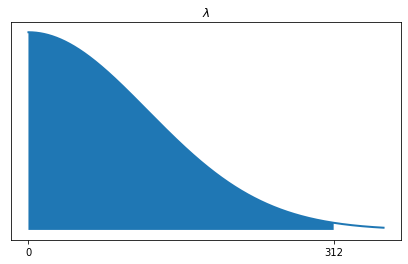

In [11]:
fig, ax2 = plt.subplots(1, 1,figsize=(7, 4))
x2=np.linspace(0,3*sigma,1000)
x4=np.linspace(0,lam_ub[0],1000)
ax2.plot(x2,2*stats.norm.pdf(x2,scale=sigma),linewidth=2)
ax2.fill_between(x4,2*stats.norm.pdf(x4,scale=sigma),0)
ax2.set_yticks([])
ax2.set_xticks([0,lam_ub[0]])
ax2.set_title(r'$\lambda$')
plt.show()

## Prior predictive distribution

In [18]:
airline_FA_hn_ppc = """
data {
  int sigma; //poisson lambda argument
}


generated quantities {
  real lambda=fabs(normal_rng(0,sigma));
  int y_sim = poisson_rng(lambda);
}
"""
model_prior = pystan.StanModel(model_code = airline_FA_hn_ppc)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3ff5369e58b5c76910ab3af92af1a4e3 NOW.


In [13]:
## generation of vector for plotting samples under histograms
acc=[]
dta_cnt=[]
for k in flights_data['Fatal accidents']:  
    dta_cnt.append(-(1.+acc.count(k)))
    acc.append(k)
dta_cnt=np.array(dta_cnt)

In [19]:
R = 1000
sim_uf = model_prior.sampling(data={'sigma': int(sigma)},
                            algorithm="Fixed_param",
                            iter=R,
                            warmup=0,
                            chains=1, 
                            refresh=R,
                            seed=29042020)

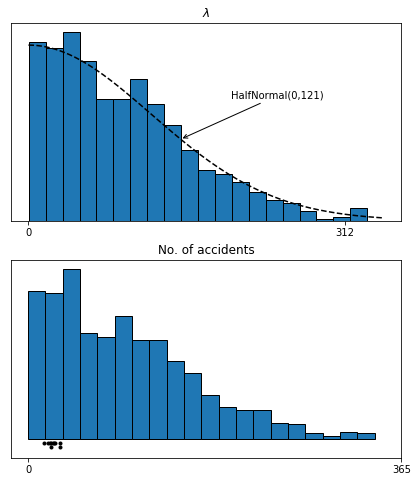

In [27]:
params=sim_uf.extract()
theta=params['lambda']
y_sim=params['y_sim']

fig, axes = plt.subplots(2, 1,figsize=(7, 8))
ax1=axes[0]
ax1.hist(theta,bins=20,edgecolor='black',density=True)
x=np.linspace(0,350,2000)
ax1.set_xticks([0,lam_ub[0]])
ax1.set_yticks([])
ax1.set_title(r'$\lambda$')
ax1.plot(x,2*stats.norm.pdf(x,0,sigma),color='black',linestyle='--')
arr_y_loc = 2*stats.norm.pdf(150,0,sigma)
ax1.annotate('HalfNormal(0,'+str(np.int(sigma))+')',xy=(150,arr_y_loc),xytext=(200,1.5*arr_y_loc),arrowprops={'arrowstyle':'->'})
ax2=axes[1]
ax2.hist(y_sim.flatten(),edgecolor='black',density=True,bins=20,zorder=1)
ax2.scatter(acc,0.0002*dta_cnt,color='black',marker='.',zorder=2)
ax2.set_xticks([0,365])
ax2.set_yticks([])

ax2.set_title('No. of accidents')
plt.show()

## Posterior inference and posterior predictive checks

In [30]:
airline_FA_hn_fit = """
data {
  int M;//number of years analyzed
  int y[M];//number of fatal accidents
  int sigma;
}
parameters {
  real<lower=0>lambda;
}
model {
  lambda ~ normal(0,sigma);
  for (k in 1:M) {
    y[k] ~ poisson(lambda);
  }
}
generated quantities {
  int y_sim[M];
  for (k in 1:M) {
    y_sim[k] = poisson_rng(lambda);
  }
}
"""
airline_FA_fit = pystan.StanModel(model_code = airline_FA_hn_fit)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5f3e0a0951dcb32aef5f05797b39ae82 NOW.


In [34]:
data = dict(M = len(flights_data),
            y = flights_data['Fatal accidents'],
            sigma = int(sigma))
fit = airline_FA_fit.sampling(data=data, seed=8052020)

params=fit.extract()
lam=params['lambda']
y_sim=params['y_sim']

In [35]:
mean_lam = np.mean(lam)
cinf_lam = az.hpd(lam,0.89)

hpd_width=cinf_lam[1]-cinf_lam[0]

In [36]:
print('Mean lambda : {:4.2f}'.format(mean_lam))
print('89% confidence interval: [',*['{:4.2f}'.format(k) for k in cinf_lam],']')

Mean lambda : 23.92
89% confidence interval: [ 21.51 26.62 ]


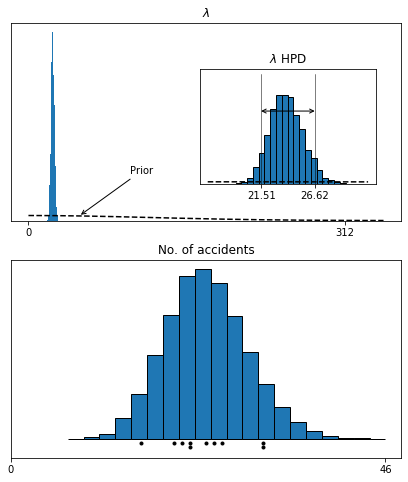

In [42]:
fig, axes = plt.subplots(2, 1,figsize=(7, 8))
ax1=axes[0]
ax1.hist(lam,bins=20,density=True)
x=np.linspace(0,350,1000)

ax1.plot(x,2*stats.norm.pdf(x,0,sigma),color='black',linestyle='--')
arr_y_loc = 2*stats.norm.pdf(50,0,sigma)
ax1.annotate('Prior',xy=(50,arr_y_loc),xytext=(100,10*arr_y_loc),arrowprops={'arrowstyle':'->'})
ax1.set_xticks([0,lam_ub[0]])

ax1.set_yticks([])
ax1.set_title(r'$\lambda$')

ax_sm=plt.axes([0.5,0.6,0.35,0.2])
x_sm=np.linspace(cinf_lam[0]-hpd_width,cinf_lam[1]+hpd_width,200)
ax_sm.hist(lam,bins=20,edgecolor='black',density=True)
ax_sm.plot(x_sm,2*stats.norm.pdf(x_sm,0,sigma),color='black',linestyle='--')
ax_sm.annotate(s='', xy=(cinf_lam[0]-.2,0.2), xytext=(cinf_lam[1]+.2,0.2), arrowprops=dict(arrowstyle='<->'))
ax_sm.plot([cinf_lam[0],cinf_lam[0]],[0,0.3],color='black',linestyle='-',linewidth=0.5)
ax_sm.plot([cinf_lam[1],cinf_lam[1]],[0,0.3],color='black',linestyle='-',linewidth=0.5)

ax_sm.set_xticks(np.round([cinf_lam[0],cinf_lam[1]],2))
ax_sm.set_yticks([])
ax_sm.set_title(r'$\lambda$ HPD')


ax2=axes[1]
ax2.hist(y_sim.flatten(),edgecolor='black',density=True,bins=20,zorder=1)
ax2.scatter(acc,0.002*dta_cnt,color='black',marker='.',zorder=2)
ax2.set_xticks([0,np.max(y_sim)])
ax2.set_yticks([])

ax2.set_title('No. of accidents')
plt.show()

## Using model for prediction

In 1977, there were 25 fatal accidents, 516 passenger deaths, and a death rate of 0.12 per 100 million miles flown. Lets check how our can perform such prediction.

In order to predict value in 1977 we just need to use the prior predictive distribution of y_sim.

In [43]:
median_y_sim = np.median(y_sim.flatten())
cinf_y_sim = az.hpd(y_sim.flatten(),0.89)

print('Median of predicted accidents =',median_y_sim)
print('Confidence interval = [',*cinf_y_sim,']')

Median of predicted accidents = 24.0
Confidence interval = [ 15.0 31.0 ]


# Modelling for accidents, considering miles

We still assume that having fatal accident every day would be very improbable. We can still use the Poisson model, however we can decompose rate $\lambda$ into intensity $\theta$ and exposure $n$. 
With $n$ being a number miles flown (in 100 mil)

$$\theta\cdot\bar{n}+3\sqrt{\theta\cdot\bar{n}}\approx365$$

Fullfiling equation above ensure us that only 1% of values will be greater or equal to 365

In [45]:
mean_miles=np.mean(flights_data['Miles flown [100 mln miles]'])
root_of_theta=np.polynomial.polynomial.polyroots([-365/mean_miles,3./np.sqrt(mean_miles),1.])
theta_ub=(root_of_theta[root_of_lam>0]**2)
print('theta upper bound','{:4.3f}'.format(theta_ub[0]))

theta upper bound 0.055


In [46]:
data=dict(y_guess=np.array([np.log(0.01)]),theta=np.array(theta_ub))
tuned2 = tuning.sampling(data=data,
                          seed=1052020,
                          algorithm="Fixed_param",
                          iter=1, 
                          warmup=0,
                          chains=1)
sigma = (tuned2.extract()['sigma'][0])
print('sigma =','{:4.3f}'.format(sigma))

sigma = 0.021


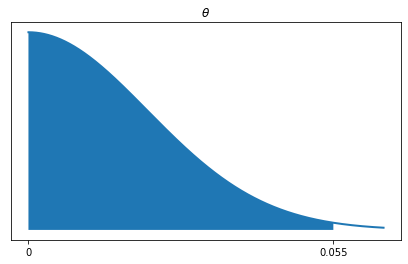

In [48]:
fig, ax2 = plt.subplots(1, 1,figsize=(7, 4))
x2=np.linspace(0,3*sigma,1000)
x4=np.linspace(0,theta_ub[0],1000)
ax2.plot(x2,2*stats.norm.pdf(x2,scale=sigma),linewidth=2)
ax2.fill_between(x4,2*stats.norm.pdf(x4,scale=sigma),0)
ax2.set_yticks([])
ax2.set_xticks([0,theta_ub[0]])
ax2.set_xticklabels([0,0.055])
ax2.set_title(r'$\theta$')
plt.show()


In [49]:
airline_FA_miles_hn_ppc = """
data {
  int M;            // number of years analyzed
  vector[M] miles;  // number of miles flown each year
  real sigma;       // sigma 
}


generated quantities {
  real theta=fabs(normal_rng(0, sigma));
  int y_sim[M];
  for (k in 1:M) {
    y_sim[k] = poisson_rng(theta*miles[k]);
  }
}
"""
model_prior = pystan.StanModel(model_code = airline_FA_miles_hn_ppc)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2ddf81aa2dde10da3e9c9e17a263724c NOW.


In [52]:
R=1000
data_prior=dict(M=len(flights_data),miles=flights_data['Miles flown [100 mln miles]'].to_numpy(), sigma=sigma)
sim_uf=model_prior.sampling(data=data_prior,algorithm="Fixed_param", iter=R, warmup=0, chains=1, refresh=R, seed=29042020)

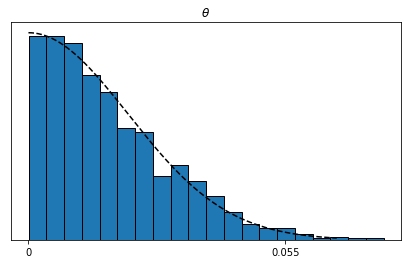

In [55]:
params=sim_uf.extract()
theta=params['theta']

fig, axes = plt.subplots(1, 1,figsize=(7, 4))
ax1=axes
ax1.hist(theta,bins=20,edgecolor='black',density=True)
x=np.linspace(0,1.2*theta_ub[0],2000)
ax1.set_xticks([0,theta_ub[0]])
ax1.set_xticklabels([0,np.round(theta_ub[0],3)])
ax1.set_yticks([])
ax1.set_title(r'$\theta$')
ax1.plot(x,2*stats.norm.pdf(x,0,sigma),color='black',linestyle='--')
arr_y_loc = 2*stats.norm.pdf(0.015,0,sigma)
plt.show()


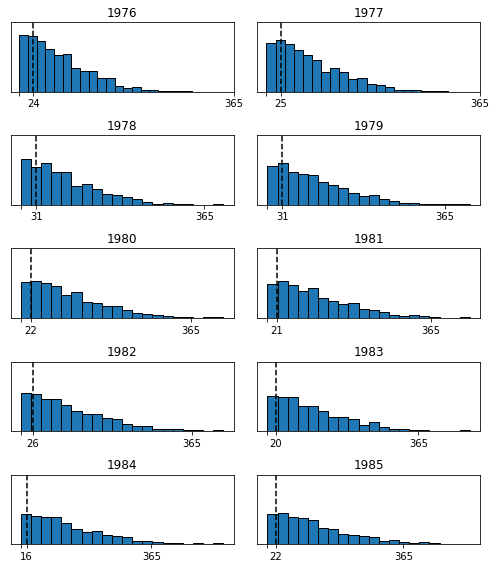

In [59]:
y_sim=params['y_sim']
fig, axes = plt.subplots(5, 2, figsize=(7, 8), sharey=True,squeeze=False)
axes_flat=axes.flatten()
for k in range(len(axes_flat)):
    ax = axes_flat[k]
    ax.hist(y_sim[:,k],bins=20,edgecolor='black',density=True)
    ax.set_title(flights_data['Year'][k])
    tv=flights_data['Fatal accidents'].iloc[k]
    ax.plot([tv,tv],[0,0.02],linestyle='--',color='black')
    ax.set_yticks([])
    ax.set_xticks([0,tv,365])
    ax.set_xticklabels(['',tv,365])
    ax.set_ylim([0,0.012])

fig.tight_layout()

plt.show()

## Posterior inference and posterior predictive checks

In [61]:
airline_FA_miles_hn_fit = """
data {
  int M;            // number of years analyzed
  vector[M] miles;  // number of miles flown each year
  int y[M];         //number of fatal accidents
  real sigma;       // sigma
}
parameters {
  real<lower=0>theta;
}
model {
  theta ~ normal(0, sigma);
  for (k in 1:M) {
    y[k] ~ poisson(miles[k]*theta);
  }
}
generated quantities {
  int y_sim[M];
  for (k in 1:M) {
    y_sim[k] = poisson_rng(miles[k]*theta);
  }
}
"""
airline_FA_miles_fit = pystan.StanModel(model_code = airline_FA_miles_hn_fit)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_346e8fffb367262d03f16480469a417e NOW.


In [66]:
data = dict(M = len(flights_data),
            miles = flights_data['Miles flown [100 mln miles]'],
            y = flights_data['Fatal accidents'],
            sigma = sigma)
fit = airline_FA_miles_fit.sampling(data=data, seed=8052020)

params_miles=fit.extract()
theta=params_miles['theta']
y_sim=params_miles['y_sim']

In [67]:
mean_theta = np.mean(theta)
cinf_theta = az.hpd(theta,0.89)
hpd_width=cinf_theta[1]-cinf_theta[0]

In [68]:
print('Mean theta : {:5.4f}'.format(mean_theta))
print('89% confidence interval: [',*['{:5.4f}'.format(k) for k in cinf_theta],']')

Mean theta : 0.0042
89% confidence interval: [ 0.0038 0.0046 ]


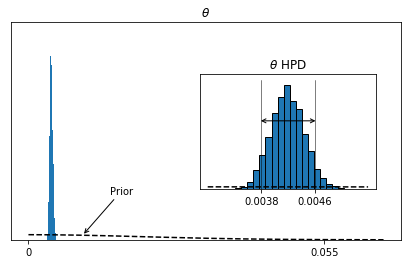

In [69]:
fig, axes = plt.subplots(1, 1,figsize=(7, 4))
ax1=axes
ax1.hist(theta,bins=20,density=True)
x=np.linspace(0,1.2*theta_ub[0],2000)
ax1.set_xticks([0,theta_ub[0]])
ax1.set_xticklabels([0,np.round(theta_ub[0],3)])
ax1.set_yticks([])
ax1.set_title(r'$\theta$')
ax1.plot(x,2*stats.norm.pdf(x,0,sigma),color='black',linestyle='--')
arr_y_loc = 2*stats.norm.pdf(0.01,0,sigma)
ax1.annotate('Prior',xy=(0.01,arr_y_loc),xytext=(0.015,10*arr_y_loc),arrowprops={'arrowstyle':'->'})

ax_sm=plt.axes([0.5,0.3,0.35,0.4])
x_sm=np.linspace(cinf_theta[0]-hpd_width,cinf_theta[1]+hpd_width,200)
ax_sm.hist(theta,bins=20,edgecolor='black',density=True)
ax_sm.plot(x_sm,2*stats.norm.pdf(x_sm,0,sigma),color='black',linestyle='--')
ax_sm.annotate(s='', xy=(0.99*cinf_theta[0],1000), xytext=(1.01*cinf_theta[1],1000), arrowprops=dict(arrowstyle='<->'))
ax_sm.plot([cinf_theta[0],cinf_theta[0]],[0,1600],color='black',linestyle='-',linewidth=0.5)
ax_sm.plot([cinf_theta[1],cinf_theta[1]],[0,1600],color='black',linestyle='-',linewidth=0.5)

ax_sm.set_xticks(([cinf_theta[0],cinf_theta[1]]))
ax_sm.set_xticklabels(np.round([cinf_theta[0],cinf_theta[1]],4))

ax_sm.set_yticks([])
ax_sm.set_title(r'$\theta$ HPD')

plt.show()


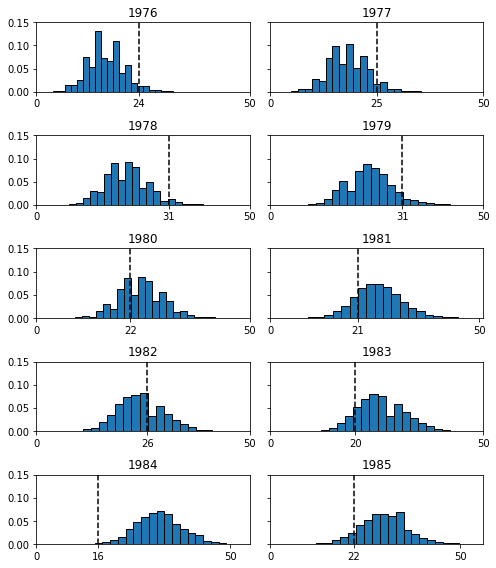

In [74]:
y_sim=params_miles['y_sim']
fig, axes = plt.subplots(5, 2, figsize=(7, 8), sharey=True,squeeze=False)
axes_flat=axes.flatten()
for k in range(len(axes_flat)):
    ax = axes_flat[k]
    ax.hist(y_sim[:,k],bins=20,edgecolor='black',density=True)
    ax.set_title(flights_data['Year'][k])
    tv=flights_data['Fatal accidents'].iloc[k]
    ax.plot([tv,tv],[0,0.15],linestyle='--',color='black')
    #ax.set_yticks([])
    ax.set_xticks([0,tv,50])
    ax.set_xticklabels([0,tv,50])
    ax.set_ylim([0,0.15])

fig.tight_layout()

plt.show()

## Using model for prediction

In this situation prediction might be a slight more complicated, as it requires from us modifying the generated quantities block As stated before in 1977, there were 25 fatal accidents, 516 passenger deaths, and a death rate of 0.12 per 100 million miles flown.

In [76]:
miles1977=516/0.12
print(np.round(miles1977))

4300.0


In [77]:
airlines_FA_miles_pred = """
data {
  int M;            // number of years analyzed
  vector[M] miles;  // number of miles flown each year
  int y[M];         //number of fatal accidents
  real sigma;       // sigma
}
parameters {
  real<lower=0>theta;
}
model {
  theta ~ normal(0,sigma);
  for (k in 1:M) {
    y[k] ~ poisson(miles[k]*theta);
  }
}
generated quantities {
  int y_1977 = poisson_rng(4300*theta);
}
"""
model1977 = pystan.StanModel(model_code = airlines_FA_miles_pred)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ad1e38fdf4e85258a5b989e3e03c01c4 NOW.


In [79]:
data = dict(M = len(flights_data),
            miles = flights_data['Miles flown [100 mln miles]'],
            y = flights_data['Fatal accidents'],
            sigma = sigma)
fit1977 = model1977.sampling(data=data, seed=8052020)

y_1977=fit1977.extract()['y_1977']

In [80]:
median_y_1977 = np.median(y_1977)
cinf_y_1977 = az.hpd(y_1977,0.89)

print('Median of predicted accidents =',median_y_1977)
print('Confidence interval = [',*cinf_y_1977,']')

Median of predicted accidents = 18.0
Confidence interval = [ 10.0 24.0 ]


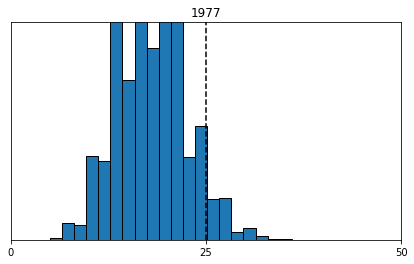

In [83]:
y_sim=params['y_sim']
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
ax.hist(y_1977,bins=20,edgecolor='black',density=True)
ax.set_title('1977')
tv = 25
ax.plot([tv,tv],[0,0.07],linestyle='--',color='black')
ax.set_yticks([])
ax.set_xticks([0,tv,50])
ax.set_xticklabels(['0',tv,50])
ax.set_ylim([0,0.07])

plt.show()